# **This script summarizes the methods for analyzing the dominant color, the average color and the brightness.**
##### Detailed information on the individual methods can be found in the separate scripts developed for the methods (in the scripts folder)

## **HINWEIS**
### Es muss nur im Code-Block "ADJUST HERE" der Spielename (siehe Auswahl im dazugehörigen Kommentar) angepasst werden. Sonst sind keine weiteren Anpassungen notwendig.

## Packages needed to be installed

In [1]:
!pip install colorthief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
from colorthief import ColorThief
from natsort import natsorted, ns
from google.colab.patches import cv2_imshow
from statistics import median 

import matplotlib.pyplot as plt
import statistics
import cv2
import os
import numpy as np
import pandas as pd

## **Connection to Google Drive**
#### *Alternatively, the mounting can also be initialized manually in the left area.*



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## ADJUST HERE! (use the names in the comment)
#### *The names in the comments are the walkthrough folder names without the suffix "_Frames".*
#### *(example: folder name "Awesome_Game_Frames" -> "Awesome_Game)*

In [3]:
# Adjust the game name (use "Diablo2", "Elden_Ring", "Half_Life_2", "Little_Nightmares", "NFS_Most_Wanted", "Siedler", "Starcraft2", "Super_Mario_World")
walkthrough_name = "Test"

## **Paths**

In [15]:
# folder in which the frames of the walkthrough are saved
walkthrough_folder = walkthrough_name + "_Frames"
path_to_game_frames = "/content/drive/MyDrive/digital_humanities/Walkthroughts/" + walkthrough_folder + "/"

# paths for the result data

# dominant color
dominant_color_result_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Color/Dominant/Barcodes/" + walkthrough_name + "/"
dominant_color_raw_data_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Color/Dominant/Raw_Data/" + walkthrough_name + "/"

# average color
average_color_result_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Color/Average/Barcodes/" + walkthrough_name + "/"
average_color_raw_data_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Color/Average/Raw_Data/" + walkthrough_name + "/"

# brightness
brightness_statistical_results_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Brightness/Results/" 
brightness_raw_data_path = "/content/drive/MyDrive/digital_humanities/Ergebnisse/Brightness/Raw_Data/"

## **Get the dominant color, average color and brightness value for every frame**
#### *for each frame the value is generated and saved in an array (for brightness in a dictionary)*
#### *show the current status of the process*
#### *show errors*
#### provide a backup in case something goes wrong *kursiver Text *kursiver Text*

In [16]:
# get all frames and sort them (unsorted, the order of the frames does not correspond to the correct order in the video.)

# list of frames in the folder
frames_list = os.listdir(path_to_game_frames)
# sorted list of frames in the folder
frames_list = natsorted(frames_list, alg=ns.PATH | ns.IGNORECASE)

# names of already analyzed frames are saved here. Serves to find out at which point the process should continue to run in the event of a process crash.
backup_check_dominant = []
backup_check_average = []
backup_check_brightness = []

# errors (name of unprocessed images are stored here)
errors_dominant = []
errors_average = []
errors_brightness = []

# generated color values are stored here
dominant_color_arr = []
mean_color_arr = []

# generated brightness values are stored here
brightness_dict = {}
brightness_row_data_dict = {}
statistic_result_dict = {}

for frame in frames_list:
  # in case there are unwanted files in the walkthrough folder
  if frame.split(".")[-1].lower() in {"jpeg", "jpg"}:

    # DOMINANT COLOR ANALYSIS --------------------------------------------------

    # conversion of the image into a ColorThief format
    ct_frame = ColorThief(path_to_game_frames + frame)
    # get the most dominant color of the image 
    dominant_color_of_ct_frame = ct_frame.get_color(quality=1)  # change quality to "2" to get the second most dominat color
    # save the color value in an array
    dominant_color_arr.append(dominant_color_of_ct_frame)
    # if something goes wrong (example: google colab time out) this array tells 
    # you which images are already processed for the dominant color analysis
    backup_check_dominant.append(frame)

    # AVERAGE COLOR ANALYSIS ---------------------------------------------------

    # conversion of the image into a cv2 workable format (this source_image is 
    # also used for the following brightness analysis)
    source_image = cv2.imread(path_to_game_frames + frame)
    # get average color of the image
    average_color_row = np.average(source_image, axis=0)
    average_color = np.average(average_color_row, axis=0)
    # convort to tuple (tuple format needed to generate the movie barcode)
    average_color_tuple = tuple(average_color)
    # save the color value in an array
    mean_color_arr.append(average_color_tuple)
    # if something goes wrong (example: google colab time out) this array tells 
    # you which images are already processed for the average color analysis
    backup_check_average.append(frame)

    # BRIGHTNESS ANALYSIS ------------------------------------------------------

    # conversion of the image into a greyscale image
    greyscale_img = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
    # get the greyscale value
    img_brightness = greyscale_img.mean()/255
    # save greyscale values
    brightness_row_data_dict[frame] = img_brightness
    brightness_dict[frame] = []
    brightness_dict[frame].append(round(img_brightness, 2))
    brightness_dict[frame].append(frame)
    # if something goes wrong (example: google colab time out) this array tells 
    # you which images are already processed for the brightness analysis
    backup_check_brightness.append(frame)

    # check for errors during the analysis process

    # for dominant color analysis                    
    if len(dominant_color_arr) != len(backup_check_dominant): 
      errors_dominant.append("[DOMINANT COLOR ERROR] " + frame)

    # for average color analysis
    if len(mean_color_arr) != len(backup_check_average): 
      errors_average.append("[AVERAGE COLOR ERROR] " + frame)

    # for brightness analysis
    if len(brightness_dict) != len(backup_check_brightness): 
      errors_brightness.append("[BRIGHTNESS ERROR] " + frame)
    
    # shows how many frames have already been analyzed
    
    if len(dominant_color_arr) == len(backup_check_dominant):
      print(f'\rProcessing: {str(len(dominant_color_arr))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    elif len(mean_color_arr) == len(backup_check_average): 
      print(f'\rProcessing: {str(len(mean_color_arr))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    elif len(brightness_dict) == len(backup_check_brightness):
      print(f'\rProcessing: {str(len(brightness_row_data_dict))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    else:
      print(f'\rProcessing: {str(len(dominant_color_arr))} [DOMINANT], {str(len(mean_color_arr))} [AVERAGE], {str(len(brightness_row_data_dict))} [BRIGHTNESS] of {str(len(frames_list))} total Frames have been analyzed.', end='')


# average color
# convort to tuple (tuple format needed to generate the movie barcode)
mean_color_arr = tuple(tuple(map(int, tup)) for tup in mean_color_arr) 

# shows the result of the analysis process
print(f'\rProcessing: {str(len(dominant_color_arr))} [DOMINANT], {str(len(mean_color_arr))} [AVERAGE], {str(len(brightness_row_data_dict))} [BRIGHTNESS] of {str(len(frames_list))} total Frames have been analyzed.', end='')

# show all frames that could not be processed due to an error
if len(errors_dominant) != 0:
  for error in errors_dominant:
    print(error)

if len(errors_average) != 0:
  for error in errors_average:
    print(error)

if len(errors_brightness) != 0:
  for error in errors_brightness:
    print(error)

Processing: 15 of 95 Frames have been analyzed.

KeyboardInterrupt: ignored

## **Continue process after disconnects, time ups, ...**
#### *Execute this code block when processing has been aborted.*
#### *Determine which frames have already been processed and continue the process from there.*

In [17]:
for frame in frames_list:
  if frame.split(".")[-1].lower() in {"jpeg", "jpg"}:

    # DOMINANT COLOR ANALYSIS --------------------------------------------------

    if frame not in backup_check_dominant:
      ct_frame = ColorThief(path_to_game_frames + frame)
      dominant_color_of_ct_frame = ct_frame.get_color(quality=1)
      dominant_color_arr.append(dominant_color_of_ct_frame)
      backup_check_dominant.append(frame)
      
    else: print(f'\rDominant Color Processing: searching for already analyzed frames', end='')

    # AVERAGE COLOR ANALYSIS ---------------------------------------------------

    if frame not in backup_check_average:
      source_image = cv2.imread(path_to_game_frames + frame)
      average_color_row = np.average(source_image, axis=0)
      average_color = np.average(average_color_row, axis=0)
      average_color_tuple = tuple(average_color)
      mean_color_arr.append(average_color_tuple)
      backup_check_average.append(frame)
      
    else: print(f'\rAverage Color Processing: searching for already analyzed frames', end='')

    # BRIGHTNESS ANALYSIS ------------------------------------------------------

    if frame not in backup_check_brightness:
      source_image = cv2.imread(path_to_game_frames + frame)
      greyscale_img = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
      img_brightness = greyscale_img.mean()/255
      brightness_row_data_dict[frame] = img_brightness
      brightness_dict[frame] = []
      brightness_dict[frame].append(round(img_brightness, 2))
      brightness_dict[frame].append(frame)
      backup_check_brightness.append(frame)
      
    else: print(f'\rBrightness Processing: searching for already analyzed frames', end='')

    # for dominant color analysis                    
    if len(dominant_color_arr) != len(backup_check_dominant): 
      errors_dominant.append("[DOMINANT COLOR ERROR] " + frame)

    # for average color analysis
    if len(mean_color_arr) != len(backup_check_average): 
      errors_average.append("[AVERAGE COLOR ERROR] " + frame)
      
    # for brightness analysis
    if len(brightness_dict) != len(backup_check_brightness): 
      errors_brightness.append("[BRIGHTNESS ERROR] " + frame)
    
    # Shows how many frames have already been analyzed
    
    if len(dominant_color_arr) == len(backup_check_dominant):
      print(f'\rProcessing: {str(len(dominant_color_arr))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    elif len(mean_color_arr) == len(backup_check_average): 
      print(f'\rProcessing: {str(len(mean_color_arr))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    elif len(brightness_dict) == len(backup_check_brightness):
      print(f'\rProcessing: {str(len(brightness_row_data_dict))} of {str(len(frames_list))} Frames have been analyzed.', end='')
    else:
      print(f'\rProcessing: {str(len(dominant_color_arr))} [DOMINANT], {str(len(mean_color_arr))} [AVERAGE], {str(len(brightness_row_data_dict))} [BRIGHTNESS] of {str(len(frames_list))} total Frames have been analyzed.', end='')


mean_color_arr = tuple(tuple(map(int, tup)) for tup in mean_color_arr) 

print(f'\rProcessing: {str(len(dominant_color_arr))} [DOMINANT], {str(len(mean_color_arr))} [AVERAGE], {str(len(brightness_row_data_dict))} [BRIGHTNESS] of {str(len(frames_list))} total Frames have been analyzed.', end='')

if len(errors_dominant) != 0:
  for error in errors_dominant:
    print(error)

if len(errors_average) != 0:
  for error in errors_average:
    print(error)

if len(errors_brightness) != 0:
  for error in errors_brightness:
    print(error)

Processing: 95 [DOMINANT], 95 [AVERAGE], 95 [BRIGHTNESS] of 95 total Frames have been analyzed.

## **Generate the movie barcodes**
#### *and saves as vector graphics (.eps, .svg) and .png and .jpg*

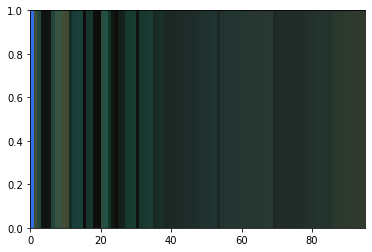

In [18]:
# AVERAGE COLOR BARCODE --------------------------------------------------------

plt.imshow([[dominant_color_arr[i] for i in range(len(dominant_color_arr))]], extent=[0,len(dominant_color_arr),0,1], aspect='auto')

plt.savefig(dominant_color_result_path + walkthrough_name + '_dominant_color_barcode.eps', format='eps')
plt.savefig(dominant_color_result_path + walkthrough_name + '_dominant_color_barcode.svg', format='svg')
plt.savefig(dominant_color_result_path + walkthrough_name + '_dominant_color_barcode.png')
plt.savefig(dominant_color_result_path + walkthrough_name + '_dominant_color_barcode.jpg')

# AVERAGE COLOR BARCODE --------------------------------------------------------

plt.imshow([[mean_color_arr[i] for i in range(len(mean_color_arr))]], extent=[0,len(mean_color_arr),0,1], aspect='auto')

plt.savefig(average_color_result_path + walkthrough_name + '_average_color_barcode.eps', format='eps')
plt.savefig(average_color_result_path + walkthrough_name + '_average_color_barcode.svg', format='svg')
plt.savefig(average_color_result_path + walkthrough_name + '_average_color_barcode.png')
plt.savefig(average_color_result_path + walkthrough_name + '_average_color_barcode.jpg')

## Generate and save csv files for dominant and average color row data

In [19]:
# key: frame name 
# value: color value
dominant_color_dict = {}
average_color_dict = {}
# used for the iteration below
arr_index = 0

# save frame name and its color value in a dictionary (easier to convert into a csv file)
if len(backup_check_dominant) == len(frames_list) and len(backup_check_average) == len(frames_list):
  for frame_name in backup_check_dominant:
    # dominant
    dominant_color_dict[frame_name] = []
    dominant_color_dict[frame_name].append(dominant_color_arr[arr_index])
    dominant_color_dict[frame_name].append(frame_name)
    # average
    average_color_dict[frame_name] = []
    average_color_dict[frame_name].append(mean_color_arr[arr_index])
    average_color_dict[frame_name].append(frame_name)

    arr_index += 1
else:
  for frame_name in backup_check_dominant:
    dominant_color_dict[frame_name] = []
    dominant_color_dict[frame_name].append(dominant_color_arr[arr_index])
    dominant_color_dict[frame_name].append(frame_name)
  
  for frame_name in backup_check_average:
    average_color_dict[frame_name] = []
    average_color_dict[frame_name].append(mean_color_arr[arr_index])
    average_color_dict[frame_name].append(frame_name)

  arr_index += 1


# convert both dictionaries to a table format and save them as a csv files
dominant_color_row_data = pd.DataFrame.from_dict(dominant_color_dict, orient='index', columns=["RGB", "frame"])
average_color_row_data = pd.DataFrame.from_dict(average_color_dict, orient='index', columns=["RGB", "frame"])

# dominant
cols_row_data = dominant_color_row_data.columns.tolist()
cols_row_data = cols_row_data[-1:] + cols_row_data[:-1]
dominant_color_row_data = dominant_color_row_data[cols_row_data]
path = dominant_color_raw_data_path + walkthrough_name + "_dominant_color_row_data.csv"
dominant_color_row_data.to_csv(path, encoding="utf-8", index=False)

# average
cols_row_data = average_color_row_data.columns.tolist()
cols_row_data = cols_row_data[-1:] + cols_row_data[:-1]
average_color_row_data = average_color_row_data[cols_row_data]
path = average_color_raw_data_path + walkthrough_name + "_average_color_row_data.csv"
average_color_row_data.to_csv(path, encoding="utf-8", index=False)

## Generete brightness data and csv

In [20]:
# get mean, median standard diviation, min and max of the brightness values
mean_brightness = sum(brightness_row_data_dict.values()) / len(brightness_dict)
sd_brightness = statistics.stdev(brightness_row_data_dict.values())
median_brightness = statistics.stdev(brightness_row_data_dict.values())
min_brightness = min(brightness_row_data_dict.values())
max_brightness = max(brightness_row_data_dict.values())

# save results in a dictionary
statistic_result_dict = {}
statistic_result_dict["min"] = []
statistic_result_dict["min"].append(round(min_brightness, 2))
statistic_result_dict["median"] = []
statistic_result_dict["median"].append(round(median_brightness, 2))
statistic_result_dict["mean"] = []
statistic_result_dict["mean"].append(round(mean_brightness, 2))
statistic_result_dict["sd"] = []
statistic_result_dict["sd"].append(round(sd_brightness, 2))
statistic_result_dict["max"] = []
statistic_result_dict["max"].append(round(max_brightness, 2))

# convert both dictionaries to a table format and save them as a csv files 
# one csv for raw data and a second for the statistical results
brightness_row_data = pd.DataFrame.from_dict(brightness_dict, orient='index', columns=["brightness_value", "frame"])
statistical_results = pd.DataFrame.from_dict(statistic_result_dict)

# row data
cols_row_data = brightness_row_data.columns.tolist()
cols_row_data = cols_row_data[-1:] + cols_row_data[:-1]
brightness_row_data = brightness_row_data[cols_row_data]
path = brightness_raw_data_path + walkthrough_name + "_brightness_row_data.csv"
brightness_row_data.to_csv(path, encoding="utf-8", index=False)

# statistical results
cols_statistics = statistical_results.columns.tolist()
cols_statistics = cols_statistics[-1:] + cols_statistics[:-1]
statistical_results = statistical_results[cols_statistics]
path = brightness_statistical_results_path + walkthrough_name + "_brightness_statistics.csv"
statistical_results.to_csv(path, encoding="utf-8", index=False)